# Heatmap Analysis of Significant Genes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyComplexHeatmap import *

In [ ]:
# Load data
expression_df = pd.read_csv('../data/processed/SRP053101/SRP053101.tsv', sep='\t')
sig_genes = pd.read_csv('../results/significant_genes_T3_vs_T0.csv')
metadata = pd.read_csv('../data/processed/SRP053101/metadata_SRP053101.tsv', sep='\t')

all_sig_genes = sig_genes['gene'].tolist()
expression_df_indexed = expression_df.set_index(expression_df.columns[0])
heatmap_data = expression_df_indexed.loc[all_sig_genes]

# Log2 transform and z-score normalize
log2_data = np.log2(heatmap_data + 1)
from scipy.stats import zscore
z_score_data = pd.DataFrame(
    zscore(log2_data, axis=1, nan_policy='omit'),
    index=log2_data.index,
    columns=log2_data.columns
).fillna(0)

# Create sample group annotation 
sample_groups = []
for sample in z_score_data.columns:
    sample_info = metadata[metadata['refinebio_accession_code'] == sample]
    if not sample_info.empty:
        title = sample_info['refinebio_title'].iloc[0]
        # Fix the logic: check for exact patterns
        if title.endswith('_T0'):
            sample_groups.append('T0')
        elif title.endswith('_T3'):
            sample_groups.append('T3')
        else:
            sample_groups.append('Unknown')
    else:
        sample_groups.append('Unknown')

col_annotation = pd.DataFrame({'Group': sample_groups}, index=z_score_data.columns)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations


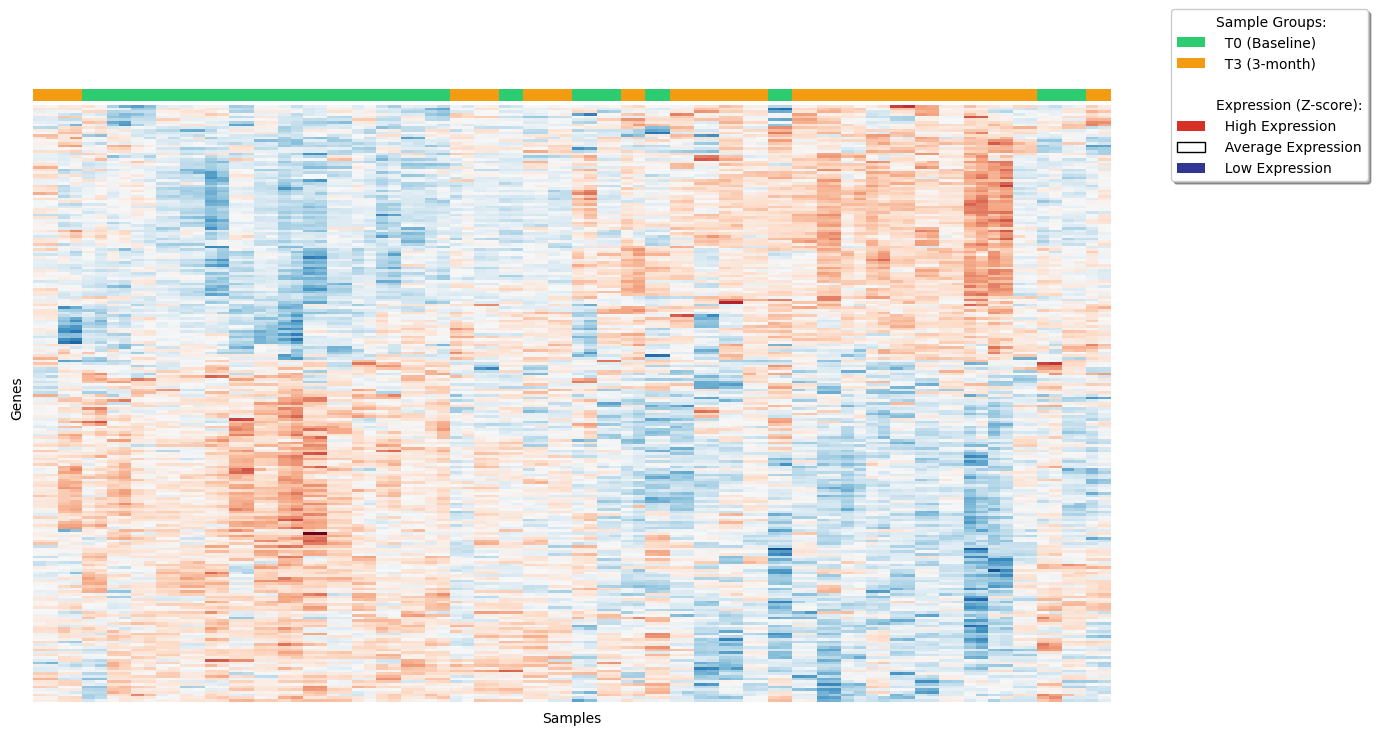

In [53]:
# Create heatmap using PyComplexHeatmap
import PyComplexHeatmap as pch

plt.figure(figsize=(14, 8))

col_annotation_no_label = pd.DataFrame({'': col_annotation['Group']}, index=col_annotation.index)

col_ha = pch.HeatmapAnnotation(
    df=col_annotation_no_label,
    colors={'': {'T0': '#2ecc71', 'T3': '#f39c12', 'Unknown': '#95a5a6'}},  # Green/Orange
    legend=True
)

cm = pch.ClusterMapPlotter(
    data=z_score_data,
    top_annotation=col_ha,
    cmap='RdBu_r',  
    center=0,
    row_cluster=True,
    col_cluster=True,
    show_rownames=False,  
    show_colnames=False,  
    plot=False,
    legend=True,
    legend_anchor='right',  
    xlabel='Samples', 
    ylabel='Genes'    
)

cm.plot()

from matplotlib.patches import Patch
import matplotlib.lines as mlines

legend_elements = [

    mlines.Line2D([], [], color='white', marker='s', linestyle='None', 
                  markersize=0, label='Sample Groups:', markerfacecolor='white'),
    Patch(facecolor='#2ecc71', label='  T0 (Baseline)'),
    Patch(facecolor='#f39c12', label='  T3 (3-month)'),
    
    mlines.Line2D([], [], color='white', marker='s', linestyle='None', 
                  markersize=0, label=' ', markerfacecolor='white'),
    
    mlines.Line2D([], [], color='white', marker='s', linestyle='None', 
                  markersize=0, label='Expression (Z-score):', markerfacecolor='white'),
    Patch(facecolor='#d73027', label='  High Expression'),
    Patch(facecolor='white', label='  Average Expression', edgecolor='black'),
    Patch(facecolor='#313695', label='  Low Expression')
]

plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.05, 0.5), 
          frameon=True, fancybox=True, shadow=True)

plt.show()